### Sign in to google to access drive. This uses an app that I wrote, should be safe.

In [67]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import os
gauth = GoogleAuth()
gauth.LocalWebserverAuth()
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=465987015783-enajp1p9qkfhldmamsaj7vgqmtofsldc.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


### This is an example of how you can get the right key for the folder you want.

In [68]:
sums_data_key = '1S8l5zsMhCqwHQR9eAZBpSnK6wziZ7SsT'

file_list = drive.ListFile({'q': f"'{sums_data_key}' in parents and trashed=false"}).GetList()
for file1 in file_list:
    print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Calibration, id: 1923wOC_XwbGt0L9o9heLBwF7mU5KPGLO
title: UV, id: 1y2th7NKfHS5fMk3poBq_vayxwLV9l2mB
title: Optical, id: 1LcFrFOqN1pBaewHwl7_jZ89BBjpbkgDV


In [69]:
calib_key = '1923wOC_XwbGt0L9o9heLBwF7mU5KPGLO'
uv_key = '1y2th7NKfHS5fMk3poBq_vayxwLV9l2mB'
optical_key = '1LcFrFOqN1pBaewHwl7_jZ89BBjpbkgDV'

file_list = drive.ListFile({'q': f"'{uv_key}' in parents and trashed=false"}).GetList()

lmc = file_list[0]['id']
smc = file_list[1]['id']

In [70]:
id = 40415
segment = 1
extension = 1
filter ='um2'

def get_file(id,segment,filter,extension,gal_id):
    file_list = drive.ListFile({'q': f"'{gal_id}' in parents and trashed=false"}).GetList()
    fname = f'sw000{id}00{segment}{filter}_sk_{id}_{segment}_{extension}'
    img_name = fname + '.new'
    cat_name = fname + '.full.dat'
    for file1 in file_list:
        if file1['title'] == img_name:
            print('Found Image')
            sname = f'temp_{id}_{segment}_{filter}_{extension}.new'
            file1.GetContentFile(sname)
            hdr = fits.open(sname)
            os.remove(sname)
        if file1['title'] == cat_name:
            print('Found Catalog')
            cname = f'temp_{id}_{segment}_{filter}_{extension}.full.dat'
            file1.GetContentFile(cname)
            cat = pd.read_csv(cname,delimiter='\s+',names=['RAhr','DEdeg','Umag','e_Umag','Bmag','e_Bmag','Vmag','e_Vmag','Imag','e_Imag','Flag','Jmag','e_Jmag','Hmag','e_Hmag','Ksmag','e_Ksmag'])
            os.remove(cname)
    return hdr,cat

In [71]:
HDR,CAT = get_file(id,segment,filter,extension,smc)

Found Catalog
Found Image


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]


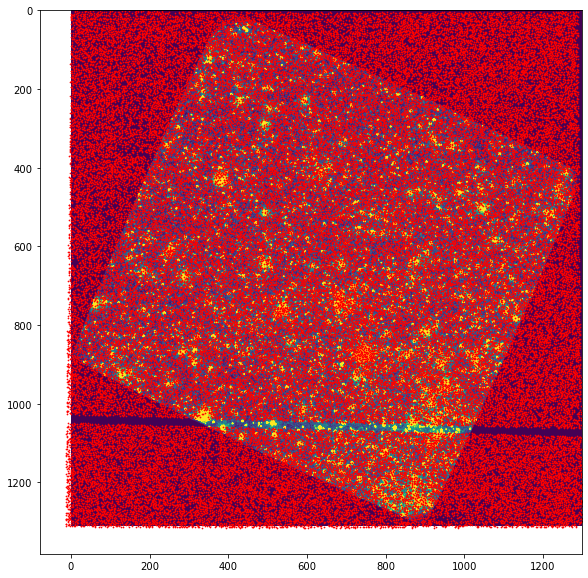

In [72]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord 
import astropy.units as u
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(HDR[0].data,vmin=0,vmax=5)
co = SkyCoord(CAT['RAhr'],CAT['DEdeg'],unit=(u.hourangle,u.deg))
x,y = co.to_pixel(WCS(HDR[0].header))
plt.scatter(x,y,c='r',s=0.5)